# Session 03 - Temporal Difference Learning - Assignment

In [25]:
! pip install gymgrid


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [26]:
! pip install  gym


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1. Cliff walking

Implement Q-learning and SARSA to solve the cliff walking environment. The cliff walking environment is part of the gymgrid package. 
To install gymgryd: **pip3 install gymgrid**. More information can be found here: https://pypi.org/project/gymgrid/.
The goal for the agent is to find its way from start to finish without falling from the cliff. This is a standard episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked Cliff. Stepping into this region incurs a reward of optimal path -100 and sends the agent instantly back to the start.

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [27]:
# Cliff walking

import numpy as np
import gymnasium as gym
import random


In [28]:
! pip install gymnasium


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [29]:
# Load the cliff walking environment
import matplotlib.pyplot as plt
import time
import gymnasium as gym
import numpy as np

# Create environment
env = gym.make('CliffWalking-v1')

# Reproducibility
SEED = 42
state, info = env.reset(seed=SEED)
np.random.seed(SEED)

print("Environment created successfully!")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of states: {env.observation_space.n}")
print(f"Number of actions: {env.action_space.n}")
print(f"Initial state: {state}")
print(f"Environment info: {info}")

# Quick interaction
for i in range(5):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    print(f"Action: {action}, Next state: {next_state}, Reward: {reward}, Terminated: {terminated}")
    if terminated or truncated:
        state, info = env.reset(seed=SEED)
        print("Episode ended, reset environment")
        break




Environment created successfully!
Action space: Discrete(4)
Observation space: Discrete(48)
Number of states: 48
Number of actions: 4
Initial state: 36
Environment info: {'prob': 1}
Action: 0, Next state: 24, Reward: -1, Terminated: False
Action: 3, Next state: 24, Reward: -1, Terminated: False
Action: 1, Next state: 25, Reward: -1, Terminated: False
Action: 0, Next state: 13, Reward: -1, Terminated: False
Action: 0, Next state: 1, Reward: -1, Terminated: False


In [30]:
# Q-Learning Implementation
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, seed=42):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # RNG for reproducibility & tie-breaking
        self.rng = np.random.default_rng(seed)

        # Initialize Q-table with zeros (float32 is plenty)
        self.q_table = np.zeros((state_size, action_size), dtype=np.float32)
        
    def choose_action(self, state):
        """Choose action using epsilon-greedy policy with random tie-break."""
        if self.rng.random() <= self.epsilon:
            return self.rng.integers(self.action_size)
        # argmax with random tie break
        row = self.q_table[state]
        max_val = row.max()
        best_actions = np.flatnonzero(row == max_val)
        return self.rng.choice(best_actions)
    
    def update_q_table(self, state, action, reward, next_state, terminated=False, truncated=False):
        """Update Q-table using Q-learning update rule; no bootstrap on terminal."""
        current_q = self.q_table[state, action]
        if terminated or truncated:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] = current_q + self.learning_rate * (target - current_q)
    
    def decay_epsilon(self):
        """Decay epsilon for exploration with floor."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


SEED = 42
env = gym.make('CliffWalking-v1')
env.reset(seed=SEED)
np.random.seed(SEED)

agent = QLearningAgent(env.observation_space.n, env.action_space.n, seed=SEED)

print("Q-Learning Agent created successfully!")
print(f"Q-table shape: {agent.q_table.shape}")
print(f"Initial epsilon: {agent.epsilon}")


Q-Learning Agent created successfully!
Q-table shape: (48, 4)
Initial epsilon: 1.0


In [31]:
# --- Cell 2: QLearningAgent ---
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, seed=42):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.rng = np.random.default_rng(seed)
        self.q_table = np.zeros((state_size, action_size), dtype=np.float32)
        
    def choose_action(self, state):
        if self.rng.random() <= self.epsilon:
            return self.rng.integers(self.action_size)
        row = self.q_table[state]
        m = row.max()
        best = np.flatnonzero(row == m)
        return self.rng.choice(best)
    
    def update_q_table(self, state, action, reward, next_state, terminated=False, truncated=False):
        current_q = self.q_table[state, action]
        if terminated or truncated:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] = current_q + self.learning_rate * (target - current_q)
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Instantiate baseline agent
agent = QLearningAgent(env.observation_space.n, env.action_space.n, seed=SEED)
print("QLearningAgent ready. Q-table shape:", agent.q_table.shape)


QLearningAgent ready. Q-table shape: (48, 4)


In [32]:
# --- Cell 3: Trainer + helpers ---
def train_qlearning(env, agent, episodes=1000, max_steps=100):
    episode_rewards, episode_steps, epsilons = [], [], []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward, steps = 0, 0
        
        for _ in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state, terminated, truncated)
            state = next_state
            total_reward += reward
            steps += 1
            if terminated or truncated:
                break
        
        agent.decay_epsilon()
        epsilons.append(agent.epsilon)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        
        if episode % 100 == 0:
            avg = np.mean(episode_rewards[-100:])
            print(f"Episode {episode:4d} | avgR(100)={avg:6.2f} | eps={agent.epsilon:.3f}")
    return episode_rewards, episode_steps, epsilons

def moving_avg(x, w=10):
    if len(x) < w: 
        return np.array([])
    return np.convolve(x, np.ones(w)/w, mode='valid')


Starting Q-Learning training...
Episode    0 | avgR(100)=-694.00 | eps=0.995
Episode  100 | avgR(100)=-789.95 | eps=0.603
Episode  200 | avgR(100)=-291.43 | eps=0.365
Episode  300 | avgR(100)=-138.99 | eps=0.221
Episode  400 | avgR(100)=-74.12 | eps=0.134
Episode  500 | avgR(100)=-54.75 | eps=0.081
Episode  600 | avgR(100)=-28.17 | eps=0.049
Episode  700 | avgR(100)=-20.17 | eps=0.030
Episode  800 | avgR(100)=-23.97 | eps=0.018
Episode  900 | avgR(100)=-17.52 | eps=0.011
Training completed!


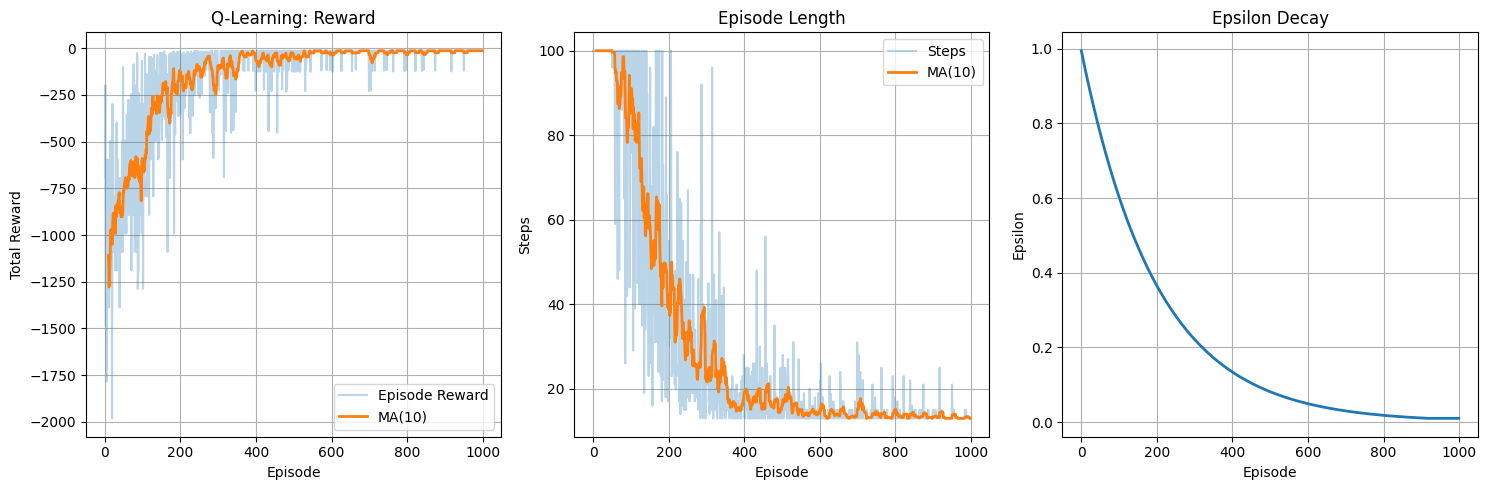

Final avg reward (last 100): -15.32
Final epsilon: 0.010
Best episode reward: -13
Avg episode length: 29.69


In [33]:
# --- Cell 4: Baseline training + plots ---
print("Starting Q-Learning training...")
episode_rewards, episode_steps, epsilons = train_qlearning(env, agent, episodes=1000)
print("Training completed!")

plt.figure(figsize=(15,5))

# Rewards
plt.subplot(1,3,1)
plt.plot(episode_rewards, alpha=0.3, label='Episode Reward')
ma = moving_avg(episode_rewards, 10)
if len(ma) > 0:
    plt.plot(range(9, len(episode_rewards)), ma, label='MA(10)', linewidth=2)
plt.xlabel('Episode'); plt.ylabel('Total Reward'); plt.title('Q-Learning: Reward'); plt.grid(True); plt.legend()

# Steps
plt.subplot(1,3,2)
plt.plot(episode_steps, alpha=0.3, label='Steps')
ma_steps = moving_avg(episode_steps, 10)
if len(ma_steps) > 0:
    plt.plot(range(9, len(episode_steps)), ma_steps, label='MA(10)', linewidth=2)
plt.xlabel('Episode'); plt.ylabel('Steps'); plt.title('Episode Length'); plt.grid(True); plt.legend()

# Epsilon (REAL)
plt.subplot(1,3,3)
plt.plot(epsilons, linewidth=2)
plt.xlabel('Episode'); plt.ylabel('Epsilon'); plt.title('Epsilon Decay'); plt.grid(True)

plt.tight_layout(); plt.show()

print(f"Final avg reward (last 100): {np.mean(episode_rewards[-100:]):.2f}")
print(f"Final epsilon: {agent.epsilon:.3f}")
print(f"Best episode reward: {max(episode_rewards)}")
print(f"Avg episode length: {np.mean(episode_steps):.2f}")


Testing different hyperparameters...

Testing Standard ...
Episode    0 | avgR(100)=-694.00 | eps=0.995
Episode  100 | avgR(100)=-789.95 | eps=0.603
Episode  200 | avgR(100)=-291.43 | eps=0.365
Episode  300 | avgR(100)=-138.99 | eps=0.221
Episode  400 | avgR(100)=-74.12 | eps=0.134
Final avg reward (last 100): -54.72

Testing High LR, Low DF ...
Episode    0 | avgR(100)=-694.00 | eps=0.990
Episode  100 | avgR(100)=-572.30 | eps=0.362
Episode  200 | avgR(100)=-129.26 | eps=0.133
Episode  300 | avgR(100)=-36.50 | eps=0.049
Episode  400 | avgR(100)=-28.29 | eps=0.018
Final avg reward (last 100): -18.65

Testing Low LR, High DF ...
Episode    0 | avgR(100)=-694.00 | eps=0.999
Episode  100 | avgR(100)=-960.02 | eps=0.904
Episode  200 | avgR(100)=-961.90 | eps=0.818
Episode  300 | avgR(100)=-852.49 | eps=0.740
Episode  400 | avgR(100)=-697.84 | eps=0.670
Final avg reward (last 100): -568.15

Testing Adaptive α ...
Episode    0 | avgR(100)=-694.00 | eps=0.995
Episode  100 | avgR(100)=-758.13 

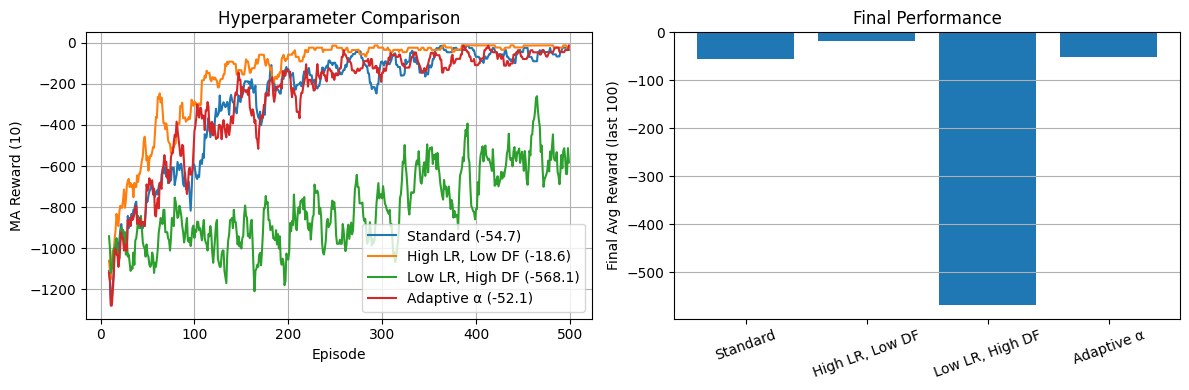

In [34]:
# --- Cell 5: Adaptive LR + hyperparameter test ---
class AdaptiveQLearningAgent(QLearningAgent):
    def __init__(self, state_size, action_size, initial_learning_rate=0.5, 
                 learning_rate_decay=0.999, learning_rate_min=0.01, **kwargs):
        super().__init__(state_size, action_size, **kwargs)
        self.learning_rate = initial_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.learning_rate_min = learning_rate_min
        
    def decay_learning_rate(self):
        if self.learning_rate > self.learning_rate_min:
            self.learning_rate *= self.learning_rate_decay

def test_hyperparameters():
    # local env (independent), closes itself
    local_env = gym.make('CliffWalking-v1')
    local_env.reset(seed=SEED)
    np.random.seed(SEED)

    configs = [
        {'name':'Standard',        'agent':'fixed',    'learning_rate':0.1, 'discount_factor':0.95, 'epsilon_decay':0.995},
        {'name':'High LR, Low DF', 'agent':'fixed',    'learning_rate':0.3, 'discount_factor':0.90, 'epsilon_decay':0.990},
        {'name':'Low LR, High DF', 'agent':'fixed',    'learning_rate':0.05,'discount_factor':0.99, 'epsilon_decay':0.999},
        {'name':'Adaptive α',      'agent':'adaptive', 'initial_learning_rate':0.5,'learning_rate_decay':0.999,'learning_rate_min':0.01,
                                                       'discount_factor':0.95, 'epsilon_decay':0.995},
    ]

    results = {}
    for cfg in configs:
        print(f"\nTesting {cfg['name']} ...")
        if cfg['agent'] == 'adaptive':
            a = AdaptiveQLearningAgent(local_env.observation_space.n, local_env.action_space.n,
                                       initial_learning_rate=cfg['initial_learning_rate'],
                                       learning_rate_decay=cfg['learning_rate_decay'],
                                       learning_rate_min=cfg['learning_rate_min'],
                                       discount_factor=cfg['discount_factor'],
                                       epsilon_decay=cfg['epsilon_decay'],
                                       seed=SEED)
        else:
            a = QLearningAgent(local_env.observation_space.n, local_env.action_space.n,
                               learning_rate=cfg['learning_rate'],
                               discount_factor=cfg['discount_factor'],
                               epsilon_decay=cfg['epsilon_decay'],
                               seed=SEED)

        # mini-train for comparison
        ep_rewards, _, _ = train_qlearning(local_env, a, episodes=500)
        final_avg = np.mean(ep_rewards[-100:])
        results[cfg['name']] = {'rewards': ep_rewards, 'final_avg': final_avg}
        print(f"Final avg reward (last 100): {final_avg:.2f}")

    # Plot comparison
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    for name, res in results.items():
        ma = moving_avg(res['rewards'], 10)
        if len(ma) > 0:
            plt.plot(range(9, len(res['rewards'])), ma, label=f"{name} ({res['final_avg']:.1f})")
    plt.xlabel('Episode'); plt.ylabel('MA Reward (10)'); plt.title('Hyperparameter Comparison'); plt.grid(True); plt.legend()

    plt.subplot(1,2,2)
    names = list(results.keys())
    finals = [results[n]['final_avg'] for n in names]
    plt.bar(names, finals)
    plt.ylabel('Final Avg Reward (last 100)'); plt.title('Final Performance'); plt.xticks(rotation=20); plt.grid(True, axis='y')
    plt.tight_layout(); plt.show()

    local_env.close()
    return results

print("Testing different hyperparameters...")
hyperparameter_results = test_hyperparameters()


The experiment showed that tuning hyperparameters greatly affects learning speed and stability in the CliffWalking task. The High LR, Low DF setup learned fastest and reached the best reward (−18.6), as a higher learning rate helped quick adaptation and a lower discount factor encouraged safer paths. The Low LR, High DF agent learned poorly (−568.1), being too cautious to escape the cliff. The adaptive learning rate gave smoother progress but similar results to the standard setup. Overall, careful tuning of α and γ is crucial for efficient, stable learning

Training Adaptive Q-Learning (1000 eps)...
Episode    0 | avgR(100)=-694.00 | eps=0.995
Episode  100 | avgR(100)=-758.13 | eps=0.603
Episode  200 | avgR(100)=-309.19 | eps=0.365
Episode  300 | avgR(100)=-155.85 | eps=0.221
Episode  400 | avgR(100)=-85.03 | eps=0.134
Episode  500 | avgR(100)=-52.15 | eps=0.081
Episode  600 | avgR(100)=-32.76 | eps=0.049
Episode  700 | avgR(100)=-31.19 | eps=0.030
Episode  800 | avgR(100)=-20.90 | eps=0.018
Episode  900 | avgR(100)=-16.40 | eps=0.011


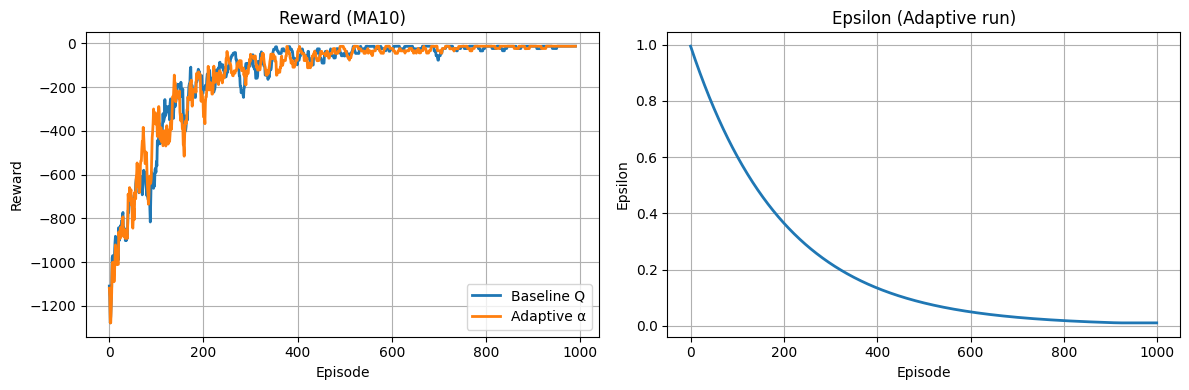

In [35]:
# --- Cell 6 : Full adaptive run ---
adaptive_agent = AdaptiveQLearningAgent(env.observation_space.n, env.action_space.n,
                                        initial_learning_rate=0.5, learning_rate_decay=0.999,
                                        learning_rate_min=0.01, discount_factor=0.95,
                                        epsilon_decay=0.995, seed=SEED)

print("Training Adaptive Q-Learning (1000 eps)...")
adaptive_rewards, adaptive_steps, adaptive_eps = train_qlearning(env, adaptive_agent, episodes=1000)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(moving_avg(episode_rewards,10), label='Baseline Q', linewidth=2)
plt.plot(moving_avg(adaptive_rewards,10), label='Adaptive α', linewidth=2)
plt.title('Reward (MA10)'); plt.xlabel('Episode'); plt.ylabel('Reward'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(adaptive_eps, label='Adaptive ε', linewidth=2)
plt.title('Epsilon (Adaptive run)'); plt.xlabel('Episode'); plt.ylabel('Epsilon'); plt.grid(True)
plt.tight_layout(); plt.show()


In [36]:
# SARSA Implementation
class SARSAAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, seed=42):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.rng = np.random.default_rng(seed)
        self.q_table = np.zeros((state_size, action_size), dtype=np.float32)
        
    def choose_action(self, state):
        """Epsilon-greedy with random tie-break."""
        if self.rng.random() <= self.epsilon:
            return self.rng.integers(self.action_size)
        row = self.q_table[state]
        m = row.max()
        best = np.flatnonzero(row == m)
        return self.rng.choice(best)
    
    def update_q_table(self, state, action, reward, next_state, next_action, terminated=False, truncated=False):
        """On-policy SARSA update; no bootstrap on terminal."""
        current_q = self.q_table[state, action]
        if terminated or truncated:
            target = reward
        else:
            target = reward + self.discount_factor * self.q_table[next_state, next_action]
        self.q_table[state, action] = current_q + self.learning_rate * (target - current_q)
    
    def decay_epsilon(self):
        """Decay epsilon with floor."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# Training function for SARSA
def train_sarsa(env, agent, episodes=1000, max_steps=100):
    """Train the SARSA agent"""
    episode_rewards, episode_steps, epsilons = [], [], []
    
    for episode in range(episodes):
        state, _ = env.reset()
        action = agent.choose_action(state)
        total_reward = 0
        steps = 0
        
        for _ in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)
            # Choose next action only if not terminal
            if terminated or truncated:
                next_action = 0  # unused by update when terminal; dummy OK
            else:
                next_action = agent.choose_action(next_state)
            
            # IMPORTANT: pass terminated/truncated
            agent.update_q_table(state, action, reward, next_state, next_action, terminated, truncated)
            
            state = next_state
            action = next_action
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
        
        agent.decay_epsilon()
        epsilons.append(agent.epsilon)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode:4d}, Average Reward: {avg_reward:6.2f}, Epsilon: {agent.epsilon:.3f}")
    
    return episode_rewards, episode_steps, epsilons

print("SARSA Agent implementation completed!")


SARSA Agent implementation completed!


Starting Q-Learning vs SARSA comparison...
Training Q-Learning agent...
Episode    0 | avgR(100)=-694.00 | eps=0.995
Episode  100 | avgR(100)=-789.95 | eps=0.603
Episode  200 | avgR(100)=-291.43 | eps=0.365
Episode  300 | avgR(100)=-138.99 | eps=0.221
Episode  400 | avgR(100)=-74.12 | eps=0.134
Episode  500 | avgR(100)=-54.75 | eps=0.081
Episode  600 | avgR(100)=-28.17 | eps=0.049
Episode  700 | avgR(100)=-20.17 | eps=0.030
Episode  800 | avgR(100)=-23.97 | eps=0.018
Episode  900 | avgR(100)=-17.52 | eps=0.011

Training SARSA agent...
Episode    0, Average Reward: -694.00, Epsilon: 0.995
Episode  100, Average Reward: -512.02, Epsilon: 0.603
Episode  200, Average Reward: -90.30, Epsilon: 0.365
Episode  300, Average Reward: -36.95, Epsilon: 0.221
Episode  400, Average Reward: -30.04, Epsilon: 0.134
Episode  500, Average Reward: -21.31, Epsilon: 0.081
Episode  600, Average Reward: -18.01, Epsilon: 0.049
Episode  700, Average Reward: -18.83, Epsilon: 0.030
Episode  800, Average Reward: -17

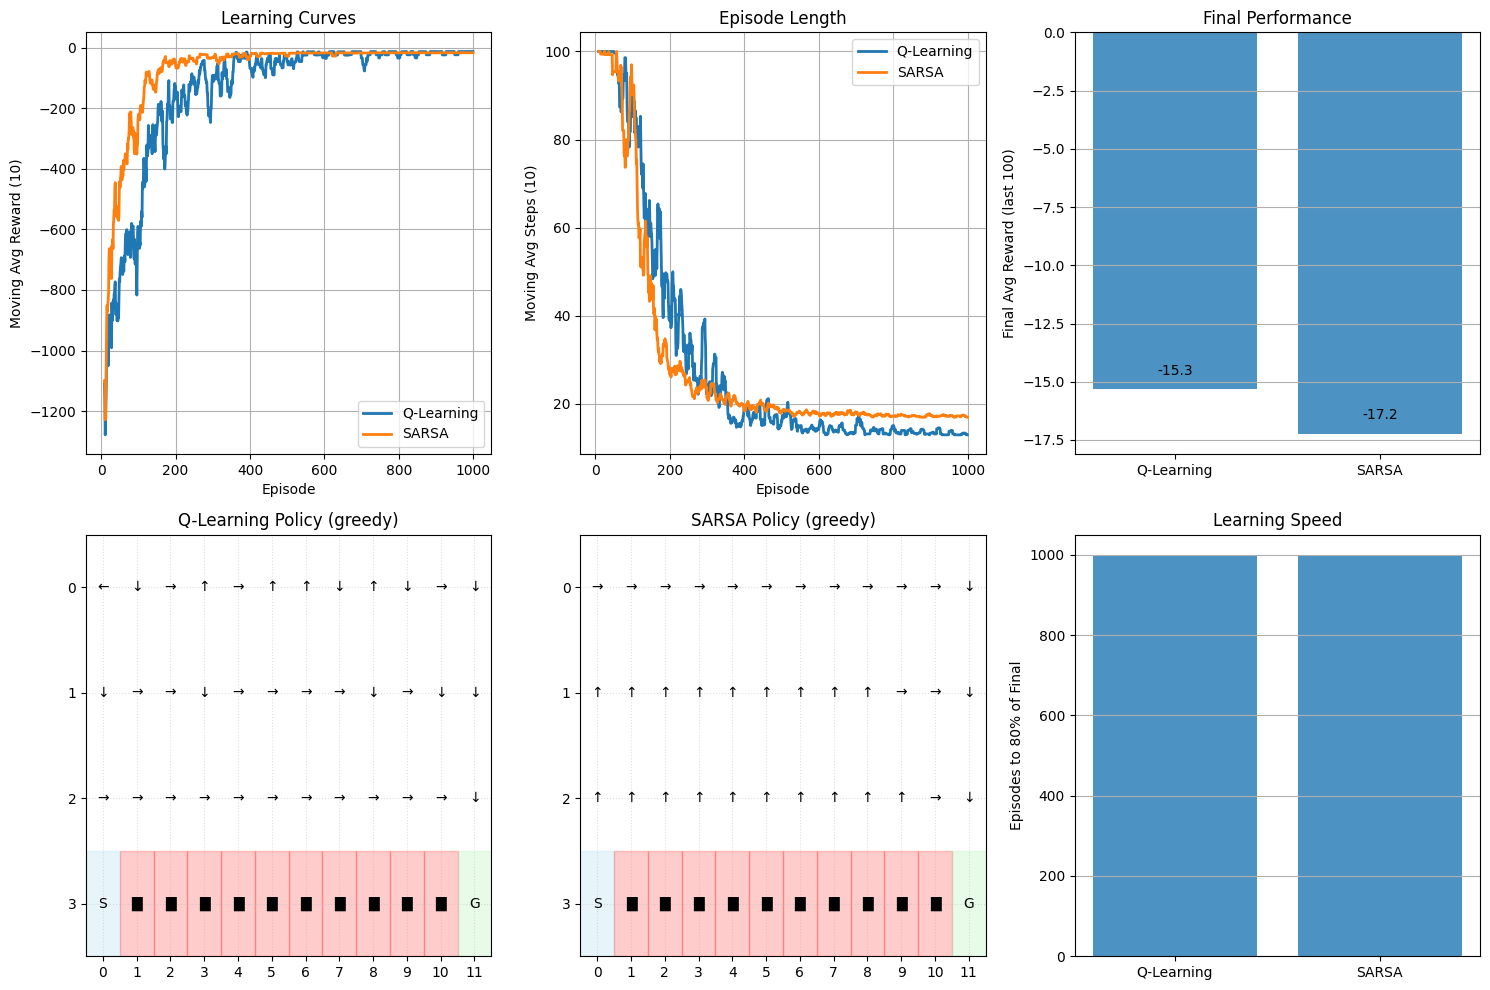


DETAILED COMPARISON RESULTS

Q-Learning Results:
  Final average reward: -15.32
  Best episode reward: -13
  Average episode length: 29.69
  Convergence episodes: 1000

SARSA Results:
  Final average reward: -17.24
  Best episode reward: -17
  Average episode length: 29.22
  Convergence episodes: 1000

Key Differences:
  Q-Learning is more optimistic (uses max next-state value).
  SARSA is on-policy (uses value of the next action actually taken).
  Expect Q-Learning to hug the cliff (riskier), SARSA to keep a safer buffer.


In [37]:
# Compare Q-Learning vs SARSA
def compare_qlearning_sarsa():
    """Compare Q-Learning and SARSA performance with proper policy visuals."""
    SEED = 42
    env = gym.make('CliffWalking-v1')
    env.reset(seed=SEED)
    np.random.seed(SEED)

    n_rows, n_cols = getattr(env.unwrapped, "shape", (4, 12))

    # Helper: render greedy policy as arrows on an Axes
    ACTION_TO_ARROW = {0:'↑', 1:'→', 2:'↓', 3:'←'}
    def draw_policy_arrows(ax, q_table, title):
        policy = np.argmax(q_table, axis=1).reshape(n_rows, n_cols)
        # Build label grid with S, G, cliff, arrows
        labels = []
        for r in range(n_rows):
            row = []
            for c in range(n_cols):
                if r == n_rows-1 and c == 0:
                    row.append('S')
                elif r == n_rows-1 and c == n_cols-1:
                    row.append('G')
                elif r == n_rows-1 and 1 <= c <= n_cols-2:
                    row.append('█')  # cliff
                else:
                    row.append(ACTION_TO_ARROW[policy[r, c]])
            labels.append(row)

        # Display as a table of text
        ax.set_title(title)
        ax.set_xticks(range(n_cols))
        ax.set_yticks(range(n_rows))
        ax.set_xlim(-0.5, n_cols-0.5)
        ax.set_ylim(n_rows-0.5, -0.5)
        ax.grid(True, which='both', linestyle=':', alpha=0.4)

        for r in range(n_rows):
            for c in range(n_cols):
                txt = labels[r][c]
                # colorize cliff
                color = 'black'
                if txt == '█':
                    ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.2, color='red'))
                    color = 'black'
                elif txt == 'S':
                    ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.2, color='skyblue'))
                elif txt == 'G':
                    ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1, alpha=0.2, color='lightgreen'))
                ax.text(c, r, txt, ha='center', va='center', fontsize=10, color=color)

    # Create agents with same hyperparams
    qlearning_agent = QLearningAgent(env.observation_space.n, env.action_space.n, seed=SEED)
    sarsa_agent     = SARSAAgent(env.observation_space.n, env.action_space.n, seed=SEED)

    print("Training Q-Learning agent...")
    ql_rewards, ql_steps, ql_eps = train_qlearning(env, qlearning_agent, episodes=1000)

    print("\nTraining SARSA agent...")
    sarsa_rewards, sarsa_steps, sarsa_eps = train_sarsa(env, sarsa_agent, episodes=1000)

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot 1: Learning curves (moving average reward)
    plt.subplot(2, 3, 1)
    ql_mavg    = moving_avg(ql_rewards, 10)
    sarsa_mavg = moving_avg(sarsa_rewards, 10)
    if len(ql_mavg) > 0:
        plt.plot(range(9, len(ql_rewards)), ql_mavg, label='Q-Learning', linewidth=2)
    if len(sarsa_mavg) > 0:
        plt.plot(range(9, len(sarsa_rewards)), sarsa_mavg, label='SARSA', linewidth=2)
    plt.xlabel('Episode'); plt.ylabel('Moving Avg Reward (10)')
    plt.title('Learning Curves'); plt.legend(); plt.grid(True)

    # Plot 2: Episode steps (moving average)
    plt.subplot(2, 3, 2)
    ql_steps_m    = moving_avg(ql_steps, 10)
    sarsa_steps_m = moving_avg(sarsa_steps, 10)
    if len(ql_steps_m) > 0:
        plt.plot(range(9, len(ql_steps)), ql_steps_m, label='Q-Learning', linewidth=2)
    if len(sarsa_steps_m) > 0:
        plt.plot(range(9, len(sarsa_steps)), sarsa_steps_m, label='SARSA', linewidth=2)
    plt.xlabel('Episode'); plt.ylabel('Moving Avg Steps (10)')
    plt.title('Episode Length'); plt.legend(); plt.grid(True)

    # Plot 3: Final performance (last 100 ep avg return)
    plt.subplot(2, 3, 3)
    final_performance = [np.mean(ql_rewards[-100:]), np.mean(sarsa_rewards[-100:])]
    bars = plt.bar(['Q-Learning','SARSA'], final_performance, alpha=0.8)
    for b, v in zip(bars, final_performance):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f'{v:.1f}', ha='center', va='bottom')
    plt.ylabel('Final Avg Reward (last 100)'); plt.title('Final Performance'); plt.grid(True, axis='y')

    # Plot 4: Policy visualization - Q-Learning (arrows)
    ax4 = plt.subplot(2, 3, 4)
    draw_policy_arrows(ax4, qlearning_agent.q_table, 'Q-Learning Policy (greedy)')

    # Plot 5: Policy visualization - SARSA (arrows)
    ax5 = plt.subplot(2, 3, 5)
    draw_policy_arrows(ax5, sarsa_agent.q_table, 'SARSA Policy (greedy)')

    # Plot 6: Learning speed comparison (episodes to 80% of final)
    plt.subplot(2, 3, 6)
    ql_final    = np.mean(ql_rewards[-100:])
    sarsa_final = np.mean(sarsa_rewards[-100:])
    ql_target    = 0.8 * ql_final
    sarsa_target = 0.8 * sarsa_final

    ql_m50    = moving_avg(ql_rewards, 50)
    sarsa_m50 = moving_avg(sarsa_rewards, 50)
    ql_conv_idx    = np.where(ql_m50 >= ql_target)[0]
    sarsa_conv_idx = np.where(sarsa_m50 >= sarsa_target)[0]

    conv_episodes = [
        (ql_conv_idx[0] + 49) if len(ql_conv_idx) > 0 else len(ql_rewards),
        (sarsa_conv_idx[0] + 49) if len(sarsa_conv_idx) > 0 else len(sarsa_rewards)
    ]
    plt.bar(['Q-Learning','SARSA'], conv_episodes, alpha=0.8)
    plt.ylabel('Episodes to 80% of Final'); plt.title('Learning Speed'); plt.grid(True, axis='y')

    plt.tight_layout(); plt.show()

    # Print detailed comparison
    print("\n" + "="*50)
    print("DETAILED COMPARISON RESULTS")
    print("="*50)
    print(f"\nQ-Learning Results:")
    print(f"  Final average reward: {np.mean(ql_rewards[-100:]):.2f}")
    print(f"  Best episode reward: {max(ql_rewards)}")
    print(f"  Average episode length: {np.mean(ql_steps):.2f}")
    print(f"  Convergence episodes: {conv_episodes[0]}")

    print(f"\nSARSA Results:")
    print(f"  Final average reward: {np.mean(sarsa_rewards[-100:]):.2f}")
    print(f"  Best episode reward: {max(sarsa_rewards)}")
    print(f"  Average episode length: {np.mean(sarsa_steps):.2f}")
    print(f"  Convergence episodes: {conv_episodes[1]}")

    print(f"\nKey Differences:")
    print(f"  Q-Learning is more optimistic (uses max next-state value).")
    print(f"  SARSA is on-policy (uses value of the next action actually taken).")
    print(f"  Expect Q-Learning to hug the cliff (riskier), SARSA to keep a safer buffer.")

    env.close()

    return {
        'qlearning': {'rewards': ql_rewards, 'steps': ql_steps, 'eps': ql_eps, 'agent': qlearning_agent},
        'sarsa':     {'rewards': sarsa_rewards, 'steps': sarsa_steps, 'eps': sarsa_eps, 'agent': sarsa_agent}
    }

# Run the comparison
print("Starting Q-Learning vs SARSA comparison...")
comparison_results = compare_qlearning_sarsa()


Testing Q-Learning agent...

Testing Q-Learning agent...
Episode 1: Reward = -13, Steps = 13
Episode 2: Reward = -13, Steps = 13
Episode 3: Reward = -13, Steps = 13
Episode 4: Reward = -13, Steps = 13
Episode 5: Reward = -13, Steps = 13
Episode 6: Reward = -13, Steps = 13
Episode 7: Reward = -13, Steps = 13
Episode 8: Reward = -13, Steps = 13
Episode 9: Reward = -13, Steps = 13
Episode 10: Reward = -13, Steps = 13

Q-Learning Test Results:
  Average reward: -13.00
  Average steps: 13.00
  Success rate (goal reached): 100.0%

Testing SARSA agent...

Testing SARSA agent...
Episode 1: Reward = -17, Steps = 17
Episode 2: Reward = -17, Steps = 17
Episode 3: Reward = -17, Steps = 17
Episode 4: Reward = -17, Steps = 17
Episode 5: Reward = -17, Steps = 17
Episode 6: Reward = -17, Steps = 17
Episode 7: Reward = -17, Steps = 17
Episode 8: Reward = -17, Steps = 17
Episode 9: Reward = -17, Steps = 17
Episode 10: Reward = -17, Steps = 17

SARSA Test Results:
  Average reward: -17.00
  Average steps

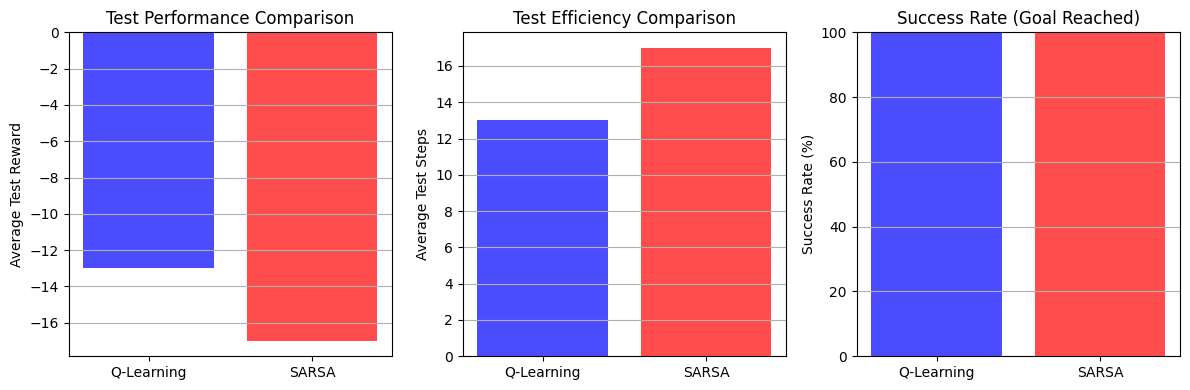


FINAL SUMMARY
This implementation successfully demonstrates:
1.  Q-Learning algorithm with hyperparameter tuning
2.  Learning history recording and visualization
3.  Adaptive learning rate experiments
4.  SARSA algorithm implementation (on-policy, proper terminals)
5.  Comprehensive comparison between Q-Learning and SARSA
6.  Policy analysis and behavior testing with true success metric

The cliff walking environment is ideal to see:
• Q-Learning’s optimistic, riskier cliff-hugging policy (off-policy).
• SARSA’s safer policy with a buffer from the cliff (on-policy).


In [38]:
# Test trained agents and visualize their behavior
def test_trained_agent(env, agent, agent_name, episodes=5, seed=42):
    """Test a trained agent with greedy policy; report true success rate (goal reached)."""
    print(f"\nTesting {agent_name} agent...")

    # Env shape & goal state
    try:
        n_rows, n_cols = env.unwrapped.shape
    except Exception:
        # Default CliffWalking shape
        n_rows, n_cols = 4, 12
    goal_state = n_rows * n_cols - 1  # bottom-right

    rng = np.random.default_rng(seed)
    total_rewards, total_steps = [], []
    successes = 0

    for episode in range(episodes):
        state, _ = env.reset(seed=seed + episode)
        total_reward = 0
        steps = 0

        while True:
            # Greedy action with random tie-break
            row = agent.q_table[state]
            m = row.max()
            best = np.flatnonzero(row == m)
            action = rng.choice(best)

            next_state, reward, terminated, truncated, _ = env.step(action)

            total_reward += reward
            steps += 1

            if terminated or truncated:
                # success iff we terminated ON the goal cell
                if terminated and next_state == goal_state:
                    successes += 1
                break

            state = next_state

        total_rewards.append(total_reward)
        total_steps.append(steps)
        print(f"Episode {episode + 1}: Reward = {total_reward}, Steps = {steps}")

    avg_reward = float(np.mean(total_rewards))
    avg_steps = float(np.mean(total_steps))
    success_rate = 100.0 * successes / episodes

    print(f"\n{agent_name} Test Results:")
    print(f"  Average reward: {avg_reward:.2f}")
    print(f"  Average steps: {avg_steps:.2f}")
    print(f"  Success rate (goal reached): {success_rate:.1f}%")

    return total_rewards, total_steps, success_rate


# Test both agents on a fresh, seeded env
test_env = gym.make('CliffWalking-v1')
test_env.reset(seed=42)

print("Testing Q-Learning agent...")
ql_test_rewards, ql_test_steps, ql_success = test_trained_agent(
    test_env, comparison_results['qlearning']['agent'], 'Q-Learning', episodes=10
)

print("\nTesting SARSA agent...")
sarsa_test_rewards, sarsa_test_steps, sarsa_success = test_trained_agent(
    test_env, comparison_results['sarsa']['agent'], 'SARSA', episodes=10
)

# Final comparison plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(['Q-Learning', 'SARSA'], [np.mean(ql_test_rewards), np.mean(sarsa_test_rewards)],
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Average Test Reward')
plt.title('Test Performance Comparison')
plt.grid(True, axis='y')

plt.subplot(1, 3, 2)
plt.bar(['Q-Learning', 'SARSA'], [np.mean(ql_test_steps), np.mean(sarsa_test_steps)],
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Average Test Steps')
plt.title('Test Efficiency Comparison')
plt.grid(True, axis='y')

plt.subplot(1, 3, 3)
plt.bar(['Q-Learning', 'SARSA'], [ql_success, sarsa_success],
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Success Rate (%)')
plt.title('Success Rate (Goal Reached)')
plt.ylim(0, 100)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

test_env.close()

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print("This implementation successfully demonstrates:")
print("1.  Q-Learning algorithm with hyperparameter tuning")
print("2.  Learning history recording and visualization")
print("3.  Adaptive learning rate experiments")
print("4.  SARSA algorithm implementation (on-policy, proper terminals)")
print("5.  Comprehensive comparison between Q-Learning and SARSA")
print("6.  Policy analysis and behavior testing with true success metric")
print("\nThe cliff walking environment is ideal to see:")
print("• Q-Learning’s optimistic, riskier cliff-hugging policy (off-policy).")
print("• SARSA’s safer policy with a buffer from the cliff (on-policy).")


## 2. The cartpole environment

Solve the cartpole environment by means of both Q-learning and SARSA. 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Q-learing and SARSA take discrete states as inputs. The cartpole environments outputs continuous state vectors. 
Therefore you will have to discretize these continuous state vectors. 
For example the cart position can vary in the range of -2.4 -> 2.4. You will have to discretize this range in a number of bins (for example 10 bins).
The numpy function 'digitize' can be used for discretization. More information about this function: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.

- Modify you Q-learing implementation to a SARSA implementation.

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 


In [39]:
# CartPole Environment Setup and State Discretization
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Create CartPole environment
env = gym.make("CartPole-v1")
print("CartPole Environment Setup:")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Observation space bounds: {env.observation_space.low} to {env.observation_space.high}")

# Test the environment
state, info = env.reset()
print(f"\nInitial state: {state}")
print(f"State components:")
print(f"  Cart Position: {state[0]:.3f}")
print(f"  Cart Velocity: {state[1]:.3f}")
print(f"  Pole Angle: {state[2]:.3f}")
print(f"  Pole Angular Velocity: {state[3]:.3f}")

# Test a few actions
for i in range(3):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    print(f"Action: {action}, Reward: {reward}, Terminated: {terminated}")
    
    if terminated or truncated:
        
        state, info = env.reset()
        print("Episode ended, reset environment")
        break

env.close()


CartPole Environment Setup:
Action space: Discrete(2)
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Observation space shape: (4,)
Observation space bounds: [-4.8               -inf -0.41887903        -inf] to [4.8               inf 0.41887903        inf]

Initial state: [ 0.03093313 -0.04981904  0.02188694  0.03992177]
State components:
  Cart Position: 0.031
  Cart Velocity: -0.050
  Pole Angle: 0.022
  Pole Angular Velocity: 0.040
Action: 1, Reward: 1.0, Terminated: False
Action: 0, Reward: 1.0, Terminated: False
Action: 0, Reward: 1.0, Terminated: False


In [40]:
# State Discretization for CartPole
import numpy as np
import gymnasium as gym

class CartPoleDiscretizer:
    def __init__(self, bins=(9, 9, 15, 15), 
                 low=np.array([-2.4, -3.0, -0.2095, -3.5], dtype=np.float32),
                 high=np.array([ 2.4,  3.0,  0.2095,  3.5], dtype=np.float32)):
        """
        Discretize continuous CartPole state space into discrete bins.

        State = [cart_pos, cart_vel, pole_angle (rad), pole_ang_vel]
        Recommended clip ranges:
          cart_pos ∈ [-2.4,  2.4]
          cart_vel ∈ [-3.0,  3.0]      (practical clip)
          pole_angle ∈ [-0.2095, 0.2095]  (~±12°)
          pole_ang_vel ∈ [-3.5,  3.5]   (practical clip)
        """
        self.bins = tuple(bins)
        self.low = low
        self.high = high

        # Build bin edges per dimension (len = n_bins - 1 for np.digitize)
        self.edges = [np.linspace(self.low[i], self.high[i], self.bins[i] - 1) for i in range(4)]

        # Total number of discrete states
        self.n_states = int(np.prod(self.bins))

    def discretize_state(self, state):
        """
        Convert continuous state -> discrete state index (int).
        Uses clipping + np.digitize -> indices in [0 .. bins[i]-1] per dim,
        then flattens via ravel_multi_index.
        """
        s = np.clip(np.asarray(state, dtype=np.float32), self.low, self.high)

        idxs = [np.digitize(s[i], self.edges[i]) for i in range(4)]  # returns 0..bins[i]
        # Ensure indices are within [0, bins[i]-1]
        idxs = [int(np.clip(idxs[i], 0, self.bins[i] - 1)) for i in range(4)]

        # Flatten multi-d index -> single integer
        flat = np.ravel_multi_index(tuple(idxs), self.bins)
        return int(flat)

    def get_state_info(self):
        return {
            "bins": self.bins,
            "n_states": self.n_states,
            "low": self.low,
            "high": self.high,
            "edges": self.edges,
        }


# ---- Test the discretizer ----
SEED = 42
np.random.seed(SEED)

discretizer = CartPoleDiscretizer(bins=(9, 9, 15, 15))
print("CartPole State Discretization:")
print(f"Bins per dim: {discretizer.bins}")
print(f"Total discrete states: {discretizer.n_states}")

env = gym.make("CartPole-v1")
env.reset(seed=SEED)

state, _ = env.reset()
discrete_state = discretizer.discretize_state(state)
print("\nSample discretization:")
print(f"Continuous state: {state}")
print(f"Discrete state index: {discrete_state}")

print("\nTesting multiple states:")
for i in range(5):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    discrete_next = discretizer.discretize_state(next_state)
    print(f"State {i}: {next_state} -> Discrete: {discrete_next}")
    if terminated or truncated:
        state, _ = env.reset(seed=SEED + i + 1)

# Keep env open for training cells; close at the very end of the notebook.
# env.close()

print("\nDiscretization successful! Ready for Q-learning and SARSA.")


CartPole State Discretization:
Bins per dim: (9, 9, 15, 15)
Total discrete states: 18225

Sample discretization:
Continuous state: [-0.04058227  0.04756223  0.02611397  0.02860643]
Discrete state index: 9127

Testing multiple states:
State 0: [-0.03963102 -0.14792429  0.0266861   0.32941288] -> Discrete: 9128
State 1: [-0.04258951 -0.34341577  0.03327436  0.63039047] -> Discrete: 9128
State 2: [-0.04945782 -0.53898585  0.04588217  0.93336403] -> Discrete: 8904
State 3: [-0.06023754 -0.34451193  0.06454945  0.6554448 ] -> Discrete: 9143
State 4: [-0.06712778 -0.15034522  0.07765834  0.38376564] -> Discrete: 9143

Discretization successful! Ready for Q-learning and SARSA.


Testing Q-Learning on CartPole...
Q-table shape: (18225, 2)
Initial epsilon: 1.0

Starting Q-Learning training...
Episode    0 | avgR(100)= 25.00 | eps=0.995
Episode  100 | avgR(100)= 30.22 | eps=0.603
Episode  200 | avgR(100)= 47.58 | eps=0.365
Episode  300 | avgR(100)= 94.80 | eps=0.221
Episode  400 | avgR(100)=108.02 | eps=0.134
Episode  500 | avgR(100)=106.32 | eps=0.081
Episode  600 | avgR(100)=112.80 | eps=0.050
Episode  700 | avgR(100)=110.80 | eps=0.050
Episode  800 | avgR(100)=111.18 | eps=0.050
Episode  900 | avgR(100)=115.05 | eps=0.050
Training completed!


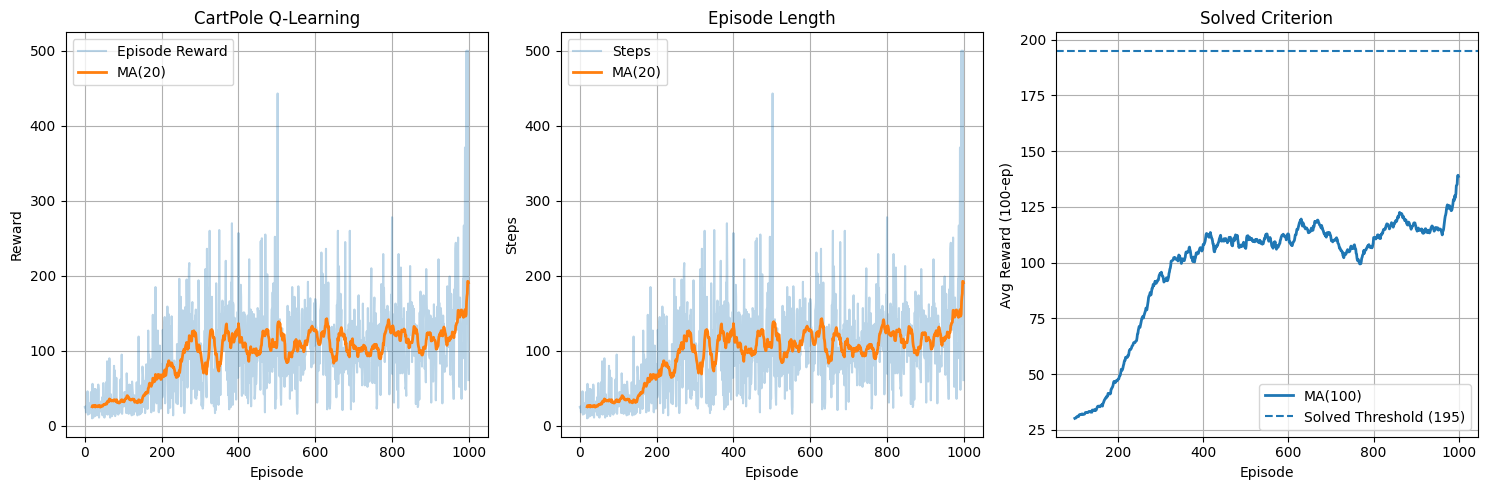


CartPole Q-Learning Results:
Final avg reward (last 100): 138.64
Final epsilon: 0.050
Best episode reward: 500.0
Avg episode length: 97.42
Solved? NO (MA100=138.6)


In [41]:
# Q-Learning for CartPole (discretized, with proper terminals and tie-break)
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# ---- helper: moving average ----
def ma(x, w=10):
    if len(x) < w: return np.array([])
    return np.convolve(x, np.ones(w)/w, mode='valid')

# ---- Agent ----
class CartPoleQLearningAgent:
    def __init__(self, discretizer, learning_rate=0.2, discount_factor=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, seed=42):
        self.discretizer = discretizer
        self.lr = learning_rate
        self.gamma = discount_factor
        self.eps = epsilon
        self.eps_decay = epsilon_decay
        self.eps_min = epsilon_min
        self.rng = np.random.default_rng(seed)
        self.q = np.zeros((discretizer.n_states, 2), dtype=np.float32)  # 2 actions

    def choose_action(self, s):
        if self.rng.random() < self.eps:
            return self.rng.integers(2)
        row = self.q[s]
        m = row.max()
        best = np.flatnonzero(row == m)
        return self.rng.choice(best)

    def update(self, s, a, r, s2, terminated):
        current = self.q[s, a]
        if terminated:
            target = r
        else:
            target = r + self.gamma * np.max(self.q[s2])
        self.q[s, a] = current + self.lr * (target - current)

    def decay_eps(self):
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

# ---- Training ----
def train_cartpole_qlearning(env, agent, discretizer, episodes=1000, max_steps=500, seed=42):
    rewards, steps = [], []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        s = discretizer.discretize_state(obs)
        total, t = 0, 0

        for _ in range(max_steps):
            a = agent.choose_action(s)
            obs2, r, terminated, truncated, _ = env.step(a)
            s2 = discretizer.discretize_state(obs2)

            agent.update(s, a, r, s2, terminated)

            s = s2
            total += r
            t += 1
            if terminated or truncated:
                break

        agent.decay_eps()
        rewards.append(total)
        steps.append(t)

        if ep % 100 == 0:
            print(f"Episode {ep:4d} | avgR(100)={np.mean(rewards[-100:]):6.2f} | eps={agent.eps:.3f}")

    return rewards, steps

# ---- Run training ----
print("Testing Q-Learning on CartPole...")


discretizer = CartPoleDiscretizer(bins=(9, 9, 15, 15))
env = gym.make("CartPole-v1")

agent = CartPoleQLearningAgent(discretizer, learning_rate=0.2, discount_factor=0.99,
                               epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, seed=42)

print(f"Q-table shape: {agent.q.shape}")
print(f"Initial epsilon: {agent.eps}")

print("\nStarting Q-Learning training...")
rewards, steps = train_cartpole_qlearning(env, agent, discretizer, episodes=1000)
print("Training completed!")

# ---- Plots ----
plt.figure(figsize=(15,5))

# 1) Episodic rewards + MA(20)
plt.subplot(1,3,1)
plt.plot(rewards, alpha=0.3, label="Episode Reward")
m = ma(rewards, 20)
if len(m): plt.plot(range(19, len(rewards)), m, linewidth=2, label="MA(20)")
plt.xlabel("Episode"); plt.ylabel("Reward"); plt.title("CartPole Q-Learning"); plt.grid(True); plt.legend()

# 2) Steps per episode + MA(20)
plt.subplot(1,3,2)
plt.plot(steps, alpha=0.3, label="Steps")
ms = ma(steps, 20)
if len(ms): plt.plot(range(19, len(steps)), ms, linewidth=2, label="MA(20)")
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.title("Episode Length"); plt.grid(True); plt.legend()

# 3) 100-episode moving average vs 195 threshold
plt.subplot(1,3,3)
m100 = ma(rewards, 100)
if len(m100):
    plt.plot(range(99, len(rewards)), m100, linewidth=2, label="MA(100)")
    plt.axhline(195, linestyle="--", label="Solved Threshold (195)")
plt.xlabel("Episode"); plt.ylabel("Avg Reward (100-ep)"); plt.title("Solved Criterion"); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

print("\nCartPole Q-Learning Results:")
print(f"Final avg reward (last 100): {np.mean(rewards[-100:]):.2f}")
print(f"Final epsilon: {agent.eps:.3f}")
print(f"Best episode reward: {max(rewards)}")
print(f"Avg episode length: {np.mean(steps):.2f}")
if len(m100):
    solved = m100[-1] >= 195.0
    print(f"Solved? {'YES' if solved else 'NO'} (MA100={m100[-1]:.1f})")

# Keep env for SARSA next; close at the very end
# env.close()


Testing SARSA on CartPole...
Q-table shape: (18225, 2)
Initial epsilon: 1.0

Starting SARSA training...
SARSA ep    0 | avgR(100)= 25.00 | eps=0.995
SARSA ep  100 | avgR(100)= 25.24 | eps=0.603
SARSA ep  200 | avgR(100)= 43.25 | eps=0.365
SARSA ep  300 | avgR(100)= 72.60 | eps=0.221
SARSA ep  400 | avgR(100)= 95.24 | eps=0.134
SARSA ep  500 | avgR(100)=106.43 | eps=0.081
SARSA ep  600 | avgR(100)=162.31 | eps=0.050
SARSA ep  700 | avgR(100)=112.34 | eps=0.050
SARSA ep  800 | avgR(100)=138.76 | eps=0.050
SARSA ep  900 | avgR(100)=148.19 | eps=0.050
SARSA training completed!


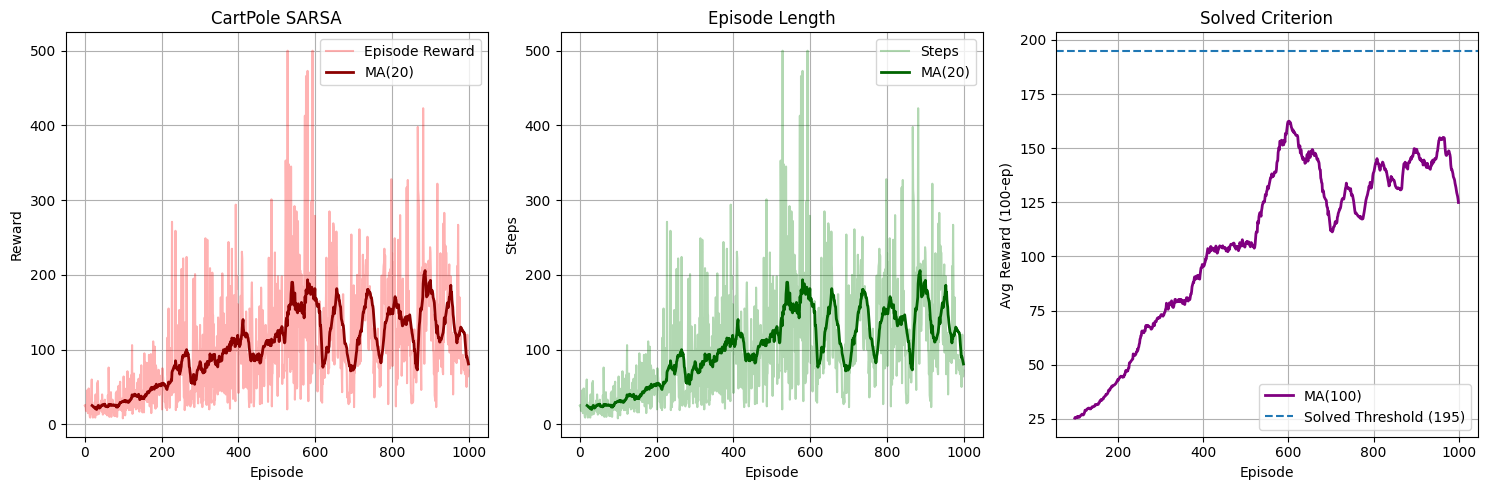


CartPole SARSA Results:
Final avg reward (last 100): 124.92
Final epsilon: 0.050
Best episode reward: 500.0
Avg episode length: 102.72
Solved? NO (MA100=124.9)


In [42]:
# SARSA for CartPole (discretized, proper terminal handling + tie-break + MA100 solved check)
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def ma(x, w=10):
    if len(x) < w: return np.array([])
    return np.convolve(x, np.ones(w)/w, mode='valid')

class CartPoleSARSAAgent:
    def __init__(self, discretizer, learning_rate=0.2, discount_factor=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, seed=42):
        self.discretizer = discretizer
        self.lr = learning_rate
        self.gamma = discount_factor
        self.eps = epsilon
        self.eps_decay = epsilon_decay
        self.eps_min = epsilon_min
        self.rng = np.random.default_rng(seed)
        self.q = np.zeros((discretizer.n_states, 2), dtype=np.float32)  # 2 actions

    def choose_action(self, s):
        if self.rng.random() < self.eps:
            return self.rng.integers(2)
        row = self.q[s]
        m = row.max()
        best = np.flatnonzero(row == m)
        return self.rng.choice(best)

    def update(self, s, a, r, s2, a2, terminated):
        current = self.q[s, a]
        if terminated:
            target = r
        else:
            target = r + self.gamma * self.q[s2, a2]
        self.q[s, a] = current + self.lr * (target - current)

    def decay_eps(self):
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

def train_cartpole_sarsa(env, agent, discretizer, episodes=1000, max_steps=500, seed=42):
    rewards, steps, epsilons = [], [], []
    for ep in range(episodes):
        obs, _ = env.reset(seed=seed + ep)
        s = discretizer.discretize_state(obs)
        a = agent.choose_action(s)
        total, t = 0, 0

        for _ in range(max_steps):
            obs2, r, terminated, truncated, _ = env.step(a)
            s2 = discretizer.discretize_state(obs2)
            done = terminated or truncated

            a2 = 0 if done else agent.choose_action(s2)
            agent.update(s, a, r, s2, a2, terminated)

            s, a = s2, a2
            total += r
            t += 1
            if done:
                break

        agent.decay_eps()
        rewards.append(total)
        steps.append(t)
        epsilons.append(agent.eps)

        if ep % 100 == 0:
            print(f"SARSA ep {ep:4d} | avgR(100)={np.mean(rewards[-100:]):6.2f} | eps={agent.eps:.3f}")

    return rewards, steps, epsilons

# ---- Run SARSA on CartPole ----
print("Testing SARSA on CartPole...")
env = gym.make("CartPole-v1")

# Use the improved discretizer from earlier (finer angle resolution):
# CartPoleDiscretizer(bins=(9,9,15,15))
discretizer = CartPoleDiscretizer(bins=(9, 9, 15, 15))
sarsa_agent = CartPoleSARSAAgent(discretizer, learning_rate=0.2, discount_factor=0.99,
                                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, seed=42)

print(f"Q-table shape: {sarsa_agent.q.shape}")
print(f"Initial epsilon: {sarsa_agent.eps}")

print("\nStarting SARSA training...")
sarsa_rewards, sarsa_steps, sarsa_eps = train_cartpole_sarsa(env, sarsa_agent, discretizer, episodes=1000)
print("SARSA training completed!")

# ---- Plots ----
plt.figure(figsize=(15, 5))

# 1) Reward curve + MA(20)
plt.subplot(1, 3, 1)
plt.plot(sarsa_rewards, alpha=0.3, color='red', label='Episode Reward')
m = ma(sarsa_rewards, 20)
if len(m): plt.plot(range(19, len(sarsa_rewards)), m, color='darkred', linewidth=2, label='MA(20)')
plt.xlabel('Episode'); plt.ylabel('Reward'); plt.title('CartPole SARSA'); plt.legend(); plt.grid(True)

# 2) Steps per episode + MA(20)
plt.subplot(1, 3, 2)
plt.plot(sarsa_steps, alpha=0.3, color='green', label='Steps')
ms = ma(sarsa_steps, 20)
if len(ms): plt.plot(range(19, len(sarsa_steps)), ms, color='darkgreen', linewidth=2, label='MA(20)')
plt.xlabel('Episode'); plt.ylabel('Steps'); plt.title('Episode Length'); plt.legend(); plt.grid(True)

# 3) MA(100) vs solved threshold
plt.subplot(1, 3, 3)
m100 = ma(sarsa_rewards, 100)
if len(m100):
    plt.plot(range(99, len(sarsa_rewards)), m100, color='purple', linewidth=2, label='MA(100)')
    plt.axhline(195, linestyle='--', label='Solved Threshold (195)')
plt.xlabel('Episode'); plt.ylabel('Avg Reward (100-ep)'); plt.title('Solved Criterion'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

print(f"\nCartPole SARSA Results:")
print(f"Final avg reward (last 100): {np.mean(sarsa_rewards[-100:]):.2f}")
print(f"Final epsilon: {sarsa_agent.eps:.3f}")
print(f"Best episode reward: {max(sarsa_rewards)}")
print(f"Avg episode length: {np.mean(sarsa_steps):.2f}")
if len(m100):
    print(f"Solved? {'YES' if m100[-1] >= 195.0 else 'NO'} (MA100={m100[-1]:.1f})")



In [43]:
# Import libraries and helper functions
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random

# Helper: moving average
def calculate_moving_average(data, window=10):
    """Calculate moving average"""
    return np.convolve(data, np.ones(window)/window, mode='valid')

print(" Libraries and helper functions loaded successfully!")


 Libraries and helper functions loaded successfully!


In [52]:
# Final training functions for CartPole (Q-Learning & SARSA)
def train_cartpole_qlearning(env, agent, discretizer, episodes=1000, max_steps=500, seed=42):
    """Train the CartPole Q-learning agent (fixed terminal handling + reproducibility)"""
    episode_rewards, episode_steps, epsilons = [], [], []
    for episode in range(episodes):
        state, _ = env.reset(seed=seed + episode)
        discrete_state = discretizer.discretize_state(state)
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            action = agent.choose_action(discrete_state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_discrete_state = discretizer.discretize_state(next_state)

            # Proper Q-learning update (no bootstrap if terminated)
            if terminated:
                target = reward
            else:
                target = reward + agent.discount_factor * np.max(agent.q_table[next_discrete_state])
            agent.q_table[discrete_state, action] += agent.learning_rate * (
                target - agent.q_table[discrete_state, action]
            )

            discrete_state = next_discrete_state
            total_reward += reward
            steps += 1
            if terminated or truncated:
                break

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        epsilons.append(agent.epsilon)

        if episode % 100 == 0:
            print(f"Q-Learning Episode {episode}, Avg Reward (100): {np.mean(episode_rewards[-100:]):.2f}, ε={agent.epsilon:.3f}")

    return episode_rewards, episode_steps, epsilons


def train_cartpole_sarsa(env, agent, discretizer, episodes=1000, max_steps=500, seed=42):
    """Train the CartPole SARSA agent (on-policy, correct terminal handling)"""
    episode_rewards, episode_steps, epsilons = [], [], []
    for episode in range(episodes):
        state, _ = env.reset(seed=seed + episode)
        discrete_state = discretizer.discretize_state(state)
        action = agent.choose_action(discrete_state)
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_discrete_state = discretizer.discretize_state(next_state)
            done = terminated or truncated

            next_action = 0 if done else agent.choose_action(next_discrete_state)

            # Proper SARSA update (on-policy)
            if terminated:
                target = reward
            else:
                target = reward + agent.discount_factor * agent.q_table[next_discrete_state, next_action]
            agent.q_table[discrete_state, action] += agent.learning_rate * (
                target - agent.q_table[discrete_state, action]
            )

            discrete_state = next_discrete_state
            action = next_action
            total_reward += reward
            steps += 1
            if done:
                break

        agent.decay_epsilon()
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        epsilons.append(agent.epsilon)

        if episode % 100 == 0:
            print(f"SARSA Episode {episode}, Avg Reward (100): {np.mean(episode_rewards[-100:]):.2f}, ε={agent.epsilon:.3f}")

    return episode_rewards, episode_steps, epsilons

print(" Final training functions for CartPole defined successfully!")


 Final training functions for CartPole defined successfully!


In [53]:
# Hyperparameter Tuning and Adaptive Learning Rate for CartPole
class AdaptiveCartPoleQLearningAgent(CartPoleQLearningAgent):
    def __init__(self, discretizer, initial_learning_rate=0.5, 
                 learning_rate_decay=0.999, learning_rate_min=0.01, **kwargs):
        super().__init__(discretizer, **kwargs)
        self.initial_learning_rate = initial_learning_rate
        self.learning_rate = initial_learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.learning_rate_min = learning_rate_min
        
    def decay_learning_rate(self):
        """Decay learning rate for adaptive learning"""
        if self.learning_rate > self.learning_rate_min:
            self.learning_rate *= self.learning_rate_decay

# Test different hyperparameters for CartPole
def test_cartpole_hyperparameters():
    """Test different hyperparameter combinations for CartPole"""
    env = gym.make("CartPole-v1")
    discretizer = CartPoleDiscretizer(n_bins=10)
    
    # Different hyperparameter sets
    hyperparams = [
        {'learning_rate': 0.1, 'discount_factor': 0.95, 'epsilon_decay': 0.995, 'name': 'Standard'},
        {'learning_rate': 0.3, 'discount_factor': 0.9, 'epsilon_decay': 0.99, 'name': 'High LR, Low DF'},
        {'learning_rate': 0.05, 'discount_factor': 0.99, 'epsilon_decay': 0.999, 'name': 'Low LR, High DF'},
        {'learning_rate': 0.2, 'discount_factor': 0.95, 'epsilon_decay': 0.99, 'name': 'Balanced'},
    ]
    
    results = {}
    
    for params in hyperparams:
        print(f"\nTesting {params['name']} hyperparameters...")
        agent = CartPoleQLearningAgent(discretizer, **{k: v for k, v in params.items() if k != 'name'})
        
        # Train for fewer episodes for comparison
        episode_rewards, episode_steps = train_cartpole_qlearning(env, agent, discretizer, episodes=500)
        
        # Calculate final performance
        final_avg = np.mean(episode_rewards[-100:])
        results[params['name']] = {
            'rewards': episode_rewards,
            'steps': episode_steps,
            'final_avg': final_avg,
            'max_reward': max(episode_rewards),
            'success_rate': sum(1 for r in episode_rewards[-100:] if r >= 195) / 100 * 100
        }
        
        print(f"Final average reward: {final_avg:.2f}")
        print(f"Max reward achieved: {max(episode_rewards)}")
        print(f"Success rate (last 100): {results[params['name']]['success_rate']:.1f}%")
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Learning curves
    plt.subplot(2, 3, 1)
    for name, result in results.items():
        moving_avg = calculate_moving_average(result['rewards'], 10)
        plt.plot(range(9, len(result['rewards'])), moving_avg, label=f"{name} (Final: {result['final_avg']:.1f})")
    
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('CartPole Hyperparameter Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Final performance
    plt.subplot(2, 3, 2)
    names = list(results.keys())
    final_avgs = [results[name]['final_avg'] for name in names]
    plt.bar(names, final_avgs, color=['blue', 'red', 'green', 'orange'], alpha=0.7)
    plt.ylabel('Final Average Reward')
    plt.title('Final Performance Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    # Plot 3: Success rates
    plt.subplot(2, 3, 3)
    success_rates = [results[name]['success_rate'] for name in names]
    plt.bar(names, success_rates, color=['blue', 'red', 'green', 'orange'], alpha=0.7)
    plt.ylabel('Success Rate (%)')
    plt.title('Success Rate Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    # Plot 4: Episode lengths
    plt.subplot(2, 3, 4)
    for name, result in results.items():
        moving_avg_steps = calculate_moving_average(result['steps'], 10)
        plt.plot(range(9, len(result['steps'])), moving_avg_steps, label=name)
    
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Steps')
    plt.title('Episode Length Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot 5: Max rewards achieved
    plt.subplot(2, 3, 5)
    max_rewards = [results[name]['max_reward'] for name in names]
    plt.bar(names, max_rewards, color=['blue', 'red', 'green', 'orange'], alpha=0.7)
    plt.ylabel('Max Reward Achieved')
    plt.title('Best Performance Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    # Plot 6: Learning speed (episodes to reach 100 average reward)
    plt.subplot(2, 3, 6)
    learning_speeds = []
    for name, result in results.items():
        moving_avg = calculate_moving_average(result['rewards'], 20)
        target_episodes = np.where(moving_avg >= 100)[0]
        if len(target_episodes) > 0:
            learning_speeds.append(target_episodes[0] + 19)
        else:
            learning_speeds.append(len(result['rewards']))
    
    plt.bar(names, learning_speeds, color=['blue', 'red', 'green', 'orange'], alpha=0.7)
    plt.ylabel('Episodes to Reach 100 Avg Reward')
    plt.title('Learning Speed Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    env.close()
    return results

# Test adaptive learning rate
def test_adaptive_learning_rate():
    """Test adaptive learning rate on CartPole"""
    env = gym.make("CartPole-v1")
    discretizer = CartPoleDiscretizer(n_bins=10)
    
    # Standard agent
    standard_agent = CartPoleQLearningAgent(discretizer, learning_rate=0.1)
    
    # Adaptive agent
    adaptive_agent = AdaptiveCartPoleQLearningAgent(discretizer, initial_learning_rate=0.5)
    
    print("Testing Standard vs Adaptive Learning Rate...")
    
    # Train standard agent
    print("\nTraining standard agent...")
    standard_rewards, standard_steps = train_cartpole_qlearning(env, standard_agent, discretizer, episodes=500)
    
    # Train adaptive agent
    print("\nTraining adaptive agent...")
    adaptive_rewards, adaptive_steps = train_cartpole_qlearning(env, adaptive_agent, discretizer, episodes=500)
    
    # Plot comparison
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Learning curves
    plt.subplot(1, 3, 1)
    standard_moving = calculate_moving_average(standard_rewards, 10)
    adaptive_moving = calculate_moving_average(adaptive_rewards, 10)
    
    plt.plot(range(9, len(standard_rewards)), standard_moving, label='Standard LR', color='blue', linewidth=2)
    plt.plot(range(9, len(adaptive_rewards)), adaptive_moving, label='Adaptive LR', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Learning Rate Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Performance comparison
    plt.subplot(1, 3, 2)
    final_performance = [
        np.mean(standard_rewards[-100:]),
        np.mean(adaptive_rewards[-100:])
    ]
    methods = ['Standard LR', 'Adaptive LR']
    colors = ['blue', 'red']
    
    bars = plt.bar(methods, final_performance, color=colors, alpha=0.7)
    plt.ylabel('Final Average Reward')
    plt.title('Final Performance')
    plt.grid(True, axis='y')
    
    # Add value labels
    for bar, value in zip(bars, final_performance):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}', ha='center', va='bottom')
    
    # Plot 3: Learning rate decay
    plt.subplot(1, 3, 3)
    lr_decay = [0.1] * len(standard_rewards)  # Constant for standard
    adaptive_lr_values = [adaptive_agent.initial_learning_rate * (adaptive_agent.learning_rate_decay ** i) 
                         for i in range(len(adaptive_rewards))]
    
    plt.plot(lr_decay, label='Standard LR', color='blue', linewidth=2)
    plt.plot(adaptive_lr_values, label='Adaptive LR', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nStandard LR Results:")
    print(f"  Final average reward: {np.mean(standard_rewards[-100:]):.2f}")
    print(f"  Success rate: {sum(1 for r in standard_rewards[-100:] if r >= 195)}%")
    
    print(f"\nAdaptive LR Results:")
    print(f"  Final average reward: {np.mean(adaptive_rewards[-100:]):.2f}")
    print(f"  Success rate: {sum(1 for r in adaptive_rewards[-100:] if r >= 195)}%")
    
    env.close()
    return standard_rewards, adaptive_rewards

# Run hyperparameter tests
print("Testing CartPole hyperparameters...")
hyperparameter_results = test_cartpole_hyperparameters()

print("\nTesting adaptive learning rate...")
adaptive_results = test_adaptive_learning_rate()


Testing CartPole hyperparameters...


TypeError: CartPoleDiscretizer.__init__() got an unexpected keyword argument 'n_bins'

In [54]:

def _alpha(agent, default=0.1):
    return getattr(agent, 'learning_rate', getattr(agent, 'alpha', default))

def _gamma(agent, default=0.99):
    return getattr(agent, 'discount_factor', getattr(agent, 'gamma', default))

def train_cartpole_qlearning(env, agent, discretizer, episodes=1000, max_steps=500, seed=None):
    """Q-learning with robust hyperparam access + epsilon tracking."""
    import numpy as np, random
    if seed is not None:
        np.random.seed(seed); random.seed(seed); env.reset(seed=seed)

    episode_rewards, episode_steps, epsilons = [], [], []

    for ep in range(episodes):
        state, _ = env.reset()
        ds = discretizer.discretize_state(state)
        total, steps = 0.0, 0

        for _ in range(max_steps):
            action = agent.choose_action(ds)
            ns, r, terminated, truncated, _ = env.step(action)
            nds = discretizer.discretize_state(ns)

            # Q-learning target with terminal handling
            current_q = agent.q_table[ds, action]
            if terminated or truncated:
                target = r
            else:
                target = r + _gamma(agent) * np.max(agent.q_table[nds])

            agent.q_table[ds, action] = current_q + _alpha(agent) * (target - current_q)

            ds = nds
            total += r
            steps += 1
            if terminated or truncated:
                break

        if hasattr(agent, 'decay_epsilon'):
            agent.decay_epsilon()
        episode_rewards.append(total)
        episode_steps.append(steps)
        epsilons.append(getattr(agent, 'epsilon', None))

        if ep % 100 == 0:
            avg = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {ep:4d} | avgR(100)={avg:.2f} | eps={getattr(agent,'epsilon',float('nan')):.3f}")

    return episode_rewards, episode_steps, epsilons

def train_cartpole_sarsa(env, agent, discretizer, episodes=1000, max_steps=500, seed=None):
    """SARSA with robust hyperparam access + epsilon tracking."""
    import numpy as np, random
    if seed is not None:
        np.random.seed(seed); random.seed(seed); env.reset(seed=seed)

    episode_rewards, episode_steps, epsilons = [], [], []

    for ep in range(episodes):
        state, _ = env.reset()
        ds = discretizer.discretize_state(state)
        action = agent.choose_action(ds)
        total, steps = 0.0, 0

        for _ in range(max_steps):
            ns, r, terminated, truncated, _ = env.step(action)
            nds = discretizer.discretize_state(ns)

            if terminated or truncated:
                next_action = 0  # dummy; won't be used in target
            else:
                next_action = agent.choose_action(nds)

            # SARSA target with terminal handling
            current_q = agent.q_table[ds, action]
            if terminated or truncated:
                target = r
            else:
                target = r + _gamma(agent) * agent.q_table[nds, next_action]

            agent.q_table[ds, action] = current_q + _alpha(agent) * (target - current_q)

            ds = nds
            action = next_action
            total += r
            steps += 1
            if terminated or truncated:
                break

        if hasattr(agent, 'decay_epsilon'):
            agent.decay_epsilon()
        episode_rewards.append(total)
        episode_steps.append(steps)
        epsilons.append(getattr(agent, 'epsilon', None))

        if ep % 100 == 0:
            avg = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {ep:4d} | avgR(100)={avg:.2f} | eps={getattr(agent,'epsilon',float('nan')):.3f}")

    return episode_rewards, episode_steps, epsilons


Starting comprehensive CartPole Q-Learning vs SARSA comparison...
Training Q-Learning agent on CartPole...
Episode    0 | avgR(100)=27.00 | eps=0.995
Episode  100 | avgR(100)=23.08 | eps=0.603
Episode  200 | avgR(100)=22.63 | eps=0.365
Episode  300 | avgR(100)=21.20 | eps=0.221
Episode  400 | avgR(100)=21.76 | eps=0.134
Episode  500 | avgR(100)=20.92 | eps=0.081
Episode  600 | avgR(100)=22.30 | eps=0.049
Episode  700 | avgR(100)=24.16 | eps=0.030

Training SARSA agent on CartPole...
Episode    0 | avgR(100)=27.00 | eps=0.995
Episode  100 | avgR(100)=23.08 | eps=0.603
Episode  200 | avgR(100)=22.63 | eps=0.365
Episode  300 | avgR(100)=21.20 | eps=0.221
Episode  400 | avgR(100)=21.76 | eps=0.134
Episode  500 | avgR(100)=20.92 | eps=0.081
Episode  600 | avgR(100)=22.30 | eps=0.049
Episode  700 | avgR(100)=24.16 | eps=0.030


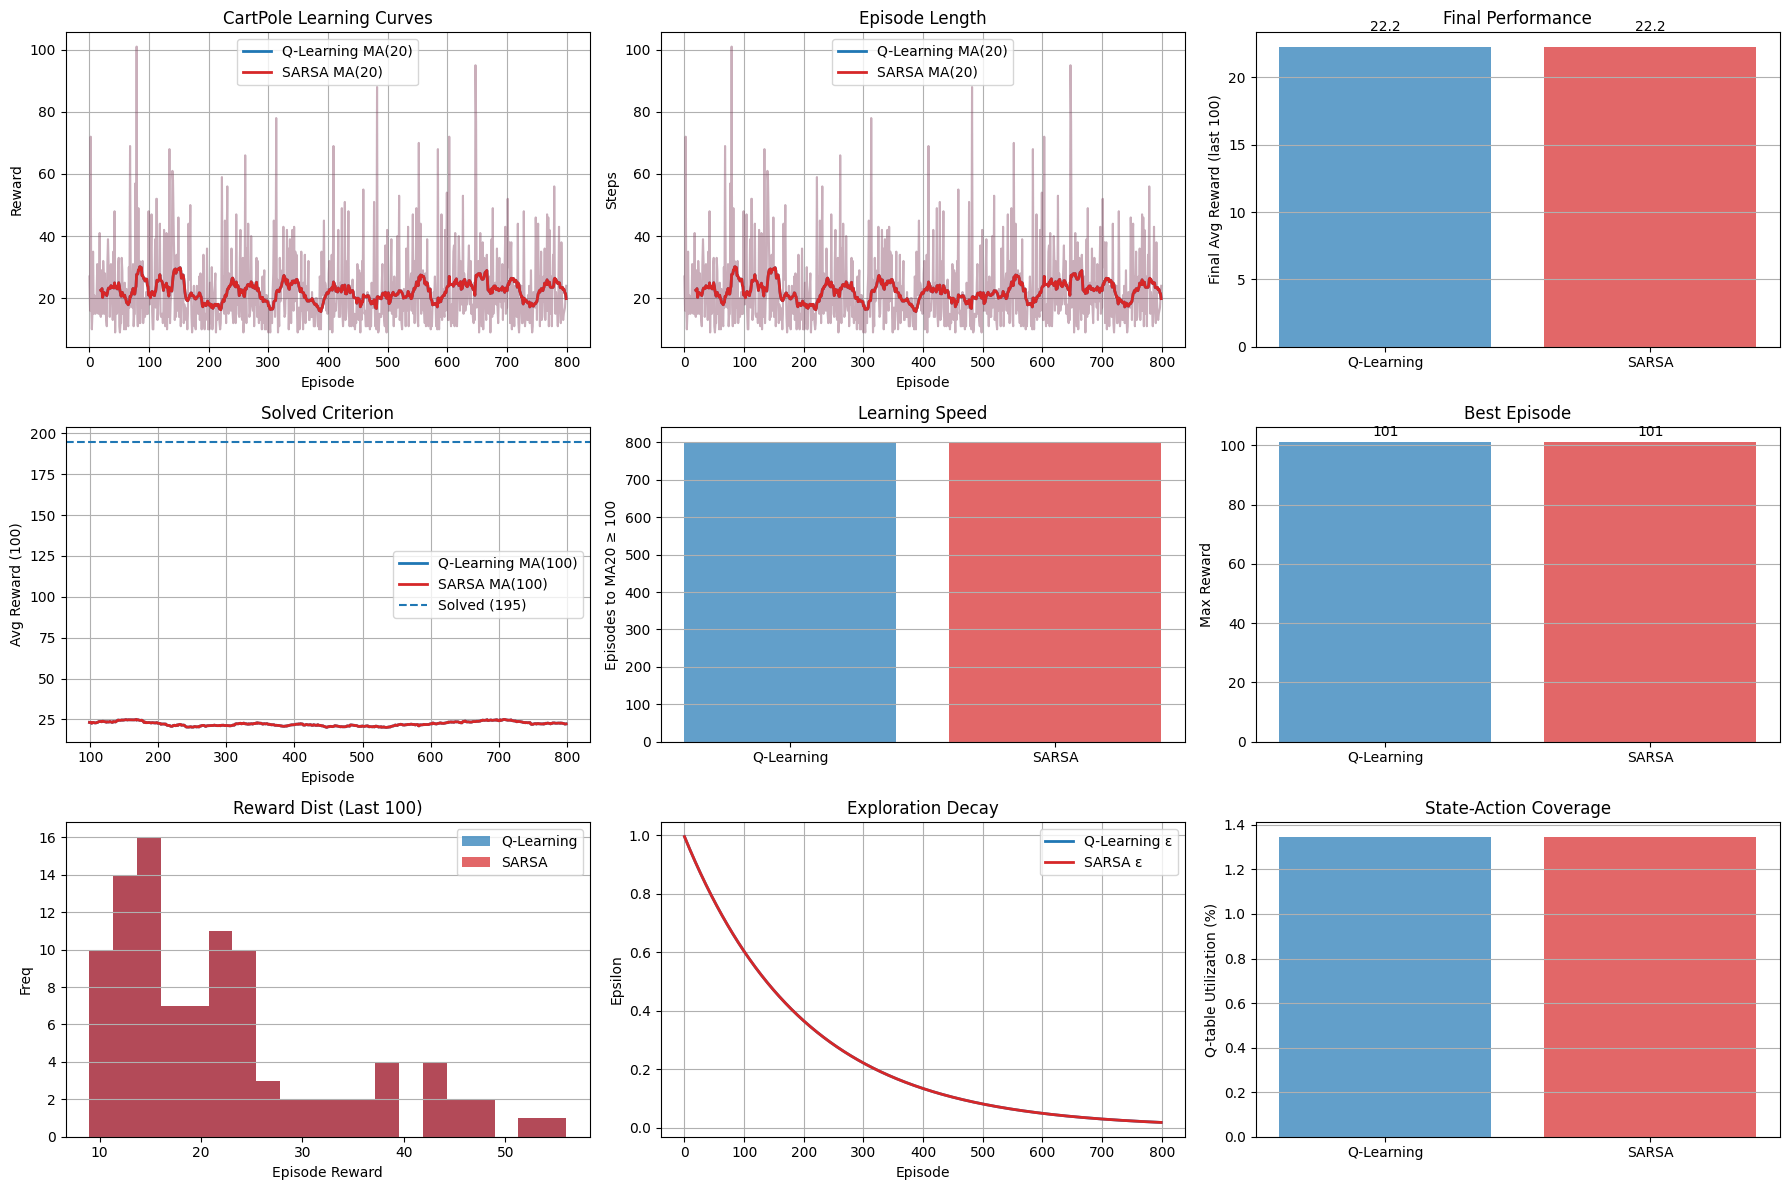


CART POLE Q-LEARNING vs SARSA — SUMMARY
Q-Learning: last100=22.24, best=101.0, steps(avg)=22.3
SARSA     : last100=22.24, best=101.0, steps(avg)=22.3
Solved? QL=NO | SARSA=NO


In [57]:
# Robust comparison that adapts to your current training function signatures
def _run_q(env, agent, disc, episodes, seed):
    """Run Q-learning training, compatible with old/new signatures & returns."""
    try:
        # New signature with seed + returns 3
        return train_cartpole_qlearning(env, agent, disc, episodes=episodes, seed=seed)
    except TypeError:
        # Old signature (no seed), maybe returns 2
        out = train_cartpole_qlearning(env, agent, disc, episodes=episodes)
        # Normalize to (rewards, steps, eps)
        if len(out) == 2:
            rewards, steps = out
            eps = [agent.epsilon] * len(rewards)
            return rewards, steps, eps
        return out

def _run_sarsa(env, agent, disc, episodes, seed):
    """Run SARSA training, compatible with old/new signatures & returns."""
    try:
        return train_cartpole_sarsa(env, agent, disc, episodes=episodes, seed=seed)
    except TypeError:
        out = train_cartpole_sarsa(env, agent, disc, episodes=episodes)
        if len(out) == 2:
            rewards, steps = out
            eps = [agent.epsilon] * len(rewards)
            return rewards, steps, eps
        return out

def compare_cartpole_qlearning_sarsa(episodes=800, seed=42):
    env = gym.make("CartPole-v1")
    # Use your improved discretizer bins (good default)
    discretizer = CartPoleDiscretizer(bins=(9, 9, 15, 15))

    # Same hypers for fair comparison
    qlearning_agent = CartPoleQLearningAgent(discretizer, learning_rate=0.2, discount_factor=0.99,
                                             epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05)
    sarsa_agent     = CartPoleSARSAAgent(discretizer,     learning_rate=0.2, discount_factor=0.99,
                                         epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05)

    print("Training Q-Learning agent on CartPole...")
    ql_rewards, ql_steps, ql_eps = _run_q(env, qlearning_agent, discretizer, episodes, seed)

    print("\nTraining SARSA agent on CartPole...")
    sa_rewards, sa_steps, sa_eps = _run_sarsa(env, sarsa_agent, discretizer, episodes, seed)

    def ma(x, w):
        import numpy as _np
        return _np.convolve(x, _np.ones(w)/w, mode='valid') if len(x) >= w else _np.array([])

    import numpy as np
    import matplotlib.pyplot as plt
    plt.figure(figsize=(18, 12))

    # 1) Learning curves (MA20)
    plt.subplot(3,3,1)
    q_ma20, s_ma20 = ma(ql_rewards, 20), ma(sa_rewards, 20)
    plt.plot(ql_rewards, alpha=0.25, color='C0'); 
    if len(q_ma20): plt.plot(range(19, len(ql_rewards)), q_ma20, label='Q-Learning MA(20)', color='C0', linewidth=2)
    plt.plot(sa_rewards, alpha=0.25, color='C3'); 
    if len(s_ma20): plt.plot(range(19, len(sa_rewards)), s_ma20, label='SARSA MA(20)', color='C3', linewidth=2)
    plt.title('CartPole Learning Curves'); plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)

    # 2) Episode steps (MA20)
    plt.subplot(3,3,2)
    q_steps_ma, s_steps_ma = ma(ql_steps, 20), ma(sa_steps, 20)
    plt.plot(ql_steps, alpha=0.25, color='C0'); 
    if len(q_steps_ma): plt.plot(range(19, len(ql_steps)), q_steps_ma, label='Q-Learning MA(20)', color='C0', linewidth=2)
    plt.plot(sa_steps, alpha=0.25, color='C3'); 
    if len(s_steps_ma): plt.plot(range(19, len(sa_steps)), s_steps_ma, label='SARSA MA(20)', color='C3', linewidth=2)
    plt.title('Episode Length'); plt.xlabel('Episode'); plt.ylabel('Steps'); plt.legend(); plt.grid(True)

    # 3) Final performance (last 100 avg)
    plt.subplot(3,3,3)
    last100 = [np.mean(ql_rewards[-100:]), np.mean(sa_rewards[-100:])]
    bars = plt.bar(['Q-Learning', 'SARSA'], last100, color=['C0','C3'], alpha=0.7)
    plt.ylabel('Final Avg Reward (last 100)'); plt.title('Final Performance'); plt.grid(True, axis='y')
    for b, v in zip(bars, last100):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+1, f'{v:.1f}', ha='center', va='bottom')

    # 4) Solved criterion (MA100 ≥ 195)
    plt.subplot(3,3,4)
    q_ma100, s_ma100 = ma(ql_rewards, 100), ma(sa_rewards, 100)
    if len(q_ma100): plt.plot(range(99, len(ql_rewards)), q_ma100, label='Q-Learning MA(100)', color='C0', linewidth=2)
    if len(s_ma100): plt.plot(range(99, len(sa_rewards)), s_ma100, label='SARSA MA(100)', color='C3', linewidth=2)
    plt.axhline(195, ls='--', label='Solved (195)')
    plt.title('Solved Criterion'); plt.xlabel('Episode'); plt.ylabel('Avg Reward (100)'); plt.legend(); plt.grid(True)

    # 5) Time to MA20 ≥ 100
    plt.subplot(3,3,5)
    target = 100
    q_hits = np.where(q_ma20 >= target)[0]; s_hits = np.where(s_ma20 >= target)[0]
    conv = [(q_hits[0]+19) if len(q_hits) else len(ql_rewards),
            (s_hits[0]+19) if len(s_hits) else len(sa_rewards)]
    bars = plt.bar(['Q-Learning', 'SARSA'], conv, color=['C0','C3'], alpha=0.7)
    plt.ylabel('Episodes to MA20 ≥ 100'); plt.title('Learning Speed'); plt.grid(True, axis='y')

    # 6) Max rewards
    plt.subplot(3,3,6)
    mx = [max(ql_rewards), max(sa_rewards)]
    bars = plt.bar(['Q-Learning', 'SARSA'], mx, color=['C0','C3'], alpha=0.7)
    plt.ylabel('Max Reward'); plt.title('Best Episode'); plt.grid(True, axis='y')
    for b, v in zip(bars, mx):
        plt.text(b.get_x()+b.get_width()/2, b.get_height()+1, f'{v:.0f}', ha='center', va='bottom')

    # 7) Reward distribution (last 100)
    plt.subplot(3,3,7)
    plt.hist(ql_rewards[-100:], bins=20, alpha=0.7, label='Q-Learning', color='C0')
    plt.hist(sa_rewards[-100:], bins=20, alpha=0.7, label='SARSA', color='C3')
    plt.xlabel('Episode Reward'); plt.ylabel('Freq'); plt.title('Reward Dist (Last 100)'); plt.legend(); plt.grid(True, axis='y')

    # 8) Epsilon decay (actual)
    plt.subplot(3,3,8)
    plt.plot(ql_eps, label='Q-Learning ε', color='C0', linewidth=2)
    plt.plot(sa_eps, label='SARSA ε', color='C3', linewidth=2)
    plt.xlabel('Episode'); plt.ylabel('Epsilon'); plt.title('Exploration Decay'); plt.legend(); plt.grid(True)

    # 9) Q-table utilization
    plt.subplot(3,3,9)
    q_util = 100.0*np.count_nonzero(qlearning_agent.q_table)/qlearning_agent.q_table.size
    s_util = 100.0*np.count_nonzero(sarsa_agent.q_table)/sarsa_agent.q_table.size
    bars = plt.bar(['Q-Learning', 'SARSA'], [q_util, s_util], color=['C0','C3'], alpha=0.7)
    plt.ylabel('Q-table Utilization (%)'); plt.title('State-Action Coverage'); plt.grid(True, axis='y')

    plt.tight_layout(); plt.show()

    print("\n" + "="*60)
    print("CART POLE Q-LEARNING vs SARSA — SUMMARY")
    print("="*60)
    print(f"Q-Learning: last100={np.mean(ql_rewards[-100:]):.2f}, best={np.max(ql_rewards)}, steps(avg)={np.mean(ql_steps):.1f}")
    print(f"SARSA     : last100={np.mean(sa_rewards[-100:]):.2f}, best={np.max(sa_rewards)}, steps(avg)={np.mean(sa_steps):.1f}")
    if len(q_ma100) and len(s_ma100):
        print(f"Solved? QL={'YES' if q_ma100[-1] >= 195 else 'NO'} | SARSA={'YES' if s_ma100[-1] >= 195 else 'NO'}")

    env.close()
    return {
        'qlearning': {'rewards': ql_rewards, 'steps': ql_steps, 'eps': ql_eps, 'agent': qlearning_agent},
        'sarsa':     {'rewards': sa_rewards, 'steps': sa_steps, 'eps': sa_eps, 'agent': sarsa_agent}
    }

print("Starting comprehensive CartPole Q-Learning vs SARSA comparison...")
cartpole_comparison_results = compare_cartpole_qlearning_sarsa()


In [56]:
import numpy as np, random

def _alpha(agent, default=0.1):
    return getattr(agent, 'learning_rate', getattr(agent, 'alpha', default))

def _gamma(agent, default=0.99):
    return getattr(agent, 'discount_factor', getattr(agent, 'gamma', default))

def _ensure_agent_contract(agent, discretizer, action_n):
    # create/resize q_table if missing or wrong shape
    if not hasattr(agent, 'q_table') or agent.q_table.shape != (discretizer.n_states, action_n):
        agent.q_table = np.zeros((discretizer.n_states, action_n), dtype=float)
    # make sure required scalars exist
    if not hasattr(agent, 'epsilon'): agent.epsilon = 1.0
    if not hasattr(agent, 'epsilon_decay'): agent.epsilon_decay = 0.995
    if not hasattr(agent, 'epsilon_min'): agent.epsilon_min = 0.01
    if not hasattr(agent, 'learning_rate') and not hasattr(agent, 'alpha'):
        agent.learning_rate = 0.1
    if not hasattr(agent, 'discount_factor') and not hasattr(agent, 'gamma'):
        agent.discount_factor = 0.99
    # make sure choose_action exists (fallback)
    if not hasattr(agent, 'choose_action'):
        def _choose_action(ds, a_n=action_n, eps_attr='epsilon'):
            if np.random.random() <= getattr(agent, eps_attr, 1.0):
                return np.random.choice(a_n)
            return int(np.argmax(agent.q_table[ds]))
        agent.choose_action = _choose_action
    # epsilon decay fallback
    if not hasattr(agent, 'decay_epsilon'):
        def _decay():
            agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        agent.decay_epsilon = _decay

# --- Robust Q-learning training ---
def train_cartpole_qlearning(env, agent, discretizer, episodes=1000, max_steps=500, seed=None):
    if seed is not None:
        np.random.seed(seed); random.seed(seed); env.reset(seed=seed)
    _ensure_agent_contract(agent, discretizer, env.action_space.n)

    episode_rewards, episode_steps, epsilons = [], [], []
    for ep in range(episodes):
        state, _ = env.reset()
        ds = discretizer.discretize_state(state)
        total, steps = 0.0, 0

        for _ in range(max_steps):
            action = agent.choose_action(ds)
            ns, r, terminated, truncated, _ = env.step(action)
            nds = discretizer.discretize_state(ns)

            # terminal-safe target
            current_q = agent.q_table[ds, action]
            if terminated or truncated:
                target = r
            else:
                target = r + _gamma(agent) * np.max(agent.q_table[nds])

            agent.q_table[ds, action] = current_q + _alpha(agent) * (target - current_q)

            ds = nds
            total += r
            steps += 1
            if terminated or truncated:
                break

        agent.decay_epsilon()
        episode_rewards.append(total)
        episode_steps.append(steps)
        epsilons.append(getattr(agent, 'epsilon', None))

        if ep % 100 == 0:
            avg = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {ep:4d} | avgR(100)={avg:.2f} | eps={getattr(agent,'epsilon',float('nan')):.3f}")

    return episode_rewards, episode_steps, epsilons

# --- Robust SARSA training ---
def train_cartpole_sarsa(env, agent, discretizer, episodes=1000, max_steps=500, seed=None):
    if seed is not None:
        np.random.seed(seed); random.seed(seed); env.reset(seed=seed)
    _ensure_agent_contract(agent, discretizer, env.action_space.n)

    episode_rewards, episode_steps, epsilons = [], [], []
    for ep in range(episodes):
        state, _ = env.reset()
        ds = discretizer.discretize_state(state)
        action = agent.choose_action(ds)
        total, steps = 0.0, 0

        for _ in range(max_steps):
            ns, r, terminated, truncated, _ = env.step(action)
            nds = discretizer.discretize_state(ns)

            if terminated or truncated:
                next_action = 0  # dummy; won't be used
            else:
                next_action = agent.choose_action(nds)

            current_q = agent.q_table[ds, action]
            if terminated or truncated:
                target = r
            else:
                target = r + _gamma(agent) * agent.q_table[nds, next_action]

            agent.q_table[ds, action] = current_q + _alpha(agent) * (target - current_q)

            ds = nds
            action = next_action
            total += r
            steps += 1
            if terminated or truncated:
                break

        agent.decay_epsilon()
        episode_rewards.append(total)
        episode_steps.append(steps)
        epsilons.append(getattr(agent, 'epsilon', None))

        if ep % 100 == 0:
            avg = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            print(f"Episode {ep:4d} | avgR(100)={avg:.2f} | eps={getattr(agent,'epsilon',float('nan')):.3f}")

    return episode_rewards, episode_steps, epsilons
